#Nạp dữ liệu

In [ ]:
#Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
)

In [ ]:
from google.colab import files
uploaded = files.upload()  # Chọn file zip

import zipfile
with zipfile.ZipFile("diabetes_prediction_dataset.csv.zip", "r") as zip_ref:
    zip_ref.extractall("data_diabetes")

Saving diabetes_prediction_dataset.csv.zip to diabetes_prediction_dataset.csv (1).zip


In [ ]:
df = pd.read_csv("data_diabetes/diabetes_prediction_dataset.csv")
# Kiểm tra thông tin dữ liệu
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0      

#TIỀN XỬ LÍ DỮ LIỆU

In [ ]:
# Kiểm tra missing values
print("\nMissing values:\n", df.isnull().sum())

# One-hot encoding cho biến phân loại
df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)


Missing values:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [ ]:
#Chia tập Train/Test
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape)

Kích thước tập huấn luyện: (80000, 13)
Kích thước tập kiểm tra: (20000, 13)


#DECISION TREE

In [ ]:
#Tìm tham số tối ưu cho Cây quyết định
params_dt = {"max_depth": [2, 3, 4, 5, 6, 8, 10]}

grid_dt = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=params_dt,
    scoring="roc_auc",
    cv=4,
    return_train_score=True,
    verbose=1
)
grid_dt.fit(X_train, y_train)

print("\nBest max_depth:", grid_dt.best_params_)

Fitting 4 folds for each of 7 candidates, totalling 28 fits

Best max_depth: {'max_depth': 10}


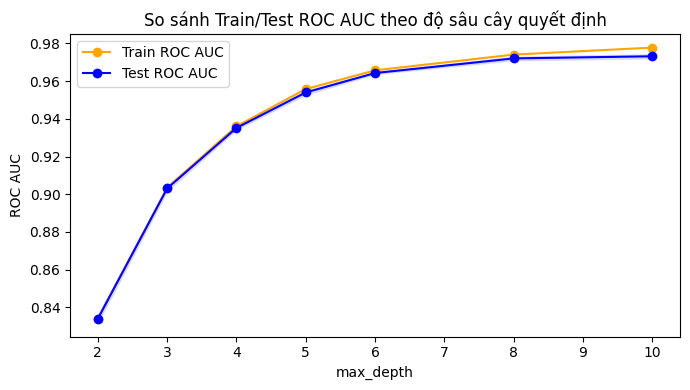

In [ ]:
#Lưu kết quả tìm tham số
cv_dt_df = pd.DataFrame(grid_dt.cv_results_)

plt.figure(figsize=(7, 4))
plt.plot(cv_dt_df["param_max_depth"], cv_dt_df["mean_train_score"], '-o', label='Train ROC AUC', color='orange')
plt.plot(cv_dt_df["param_max_depth"], cv_dt_df["mean_test_score"], '-o', label='Test ROC AUC', color='blue')
plt.fill_between(
    cv_dt_df["param_max_depth"],
    cv_dt_df["mean_test_score"] - cv_dt_df["std_test_score"] / np.sqrt(4),
    cv_dt_df["mean_test_score"] + cv_dt_df["std_test_score"] / np.sqrt(4),
    color='blue', alpha=0.1
)
plt.title("So sánh Train/Test ROC AUC theo độ sâu cây quyết định", fontsize=12)
plt.xlabel("max_depth")
plt.ylabel("ROC AUC")
plt.legend()
plt.tight_layout()
plt.savefig("decision_tree_depth_comparison.png", dpi=300)
plt.show()


--- Kết quả Cây quyết định cơ bản ---
Độ chính xác (Accuracy): 0.9723
ROC AUC: 0.939


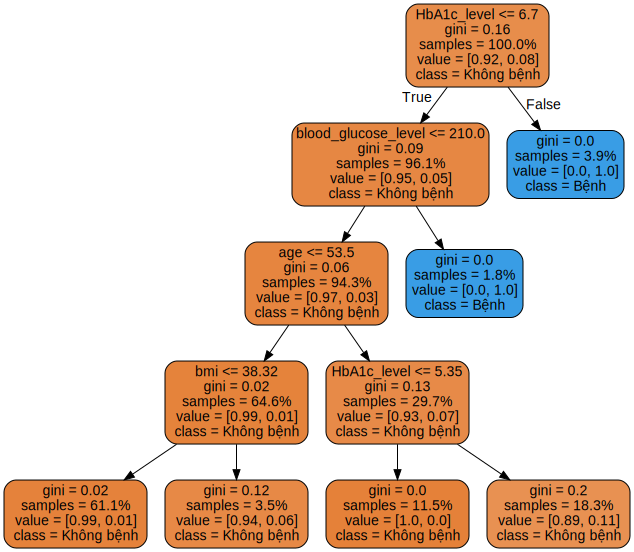

In [ ]:
#MÔ HÌNH CÂY QUYẾT ĐỊNH (DECISION TREE)
dt = tree.DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)
roc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

print("\n--- Kết quả Cây quyết định cơ bản ---")
print("Độ chính xác (Accuracy):", round(acc_dt, 4))
print("ROC AUC:", round(roc_dt, 4))
# Vẽ cây quyết định
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=X.columns,
    class_names=["Không bệnh", "Bệnh"],
    filled=True,
    rounded=True,
    proportion=True,
    impurity=True,
    precision=2
)
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png")  # Xuất ảnh cây quyết định
display(graph)

#RANDOM FOREST

In [ ]:
#MÔ HÌNH RANDOM FOREST
rf = RandomForestClassifier(
    n_estimators=50, max_depth=5, random_state=42, criterion="gini"
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print("\n--- Kết quả Rừng cây cơ bản ---")
print("Accuracy (RF):", round(acc_rf, 4))
print("ROC AUC (RF):", round(roc_rf, 4))



--- Kết quả Rừng cây cơ bản ---
Accuracy (RF): 0.9723
ROC AUC (RF): 0.9553


Fitting 4 folds for each of 10 candidates, totalling 40 fits

Best params (Random Forest): {'n_estimators': 90}


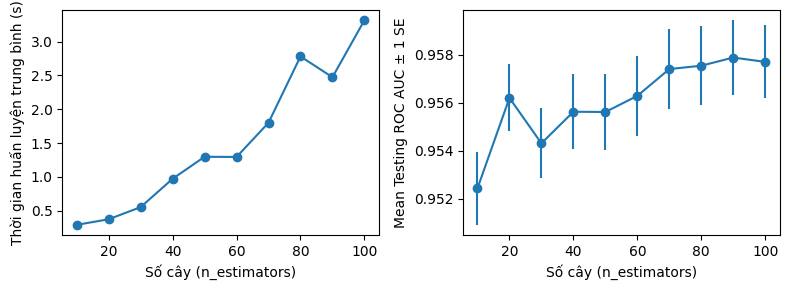

In [ ]:
#Tìm tham số tối ưu cho MÔ HÌNH RANDOM FOREST
params_rf = {"n_estimators": list(range(10, 110, 10))}
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(max_depth=5, random_state=42),
    param_grid=params_rf,
    scoring="roc_auc",
    cv=4,
    return_train_score=True,
    verbose=1
)
grid_rf.fit(X_train, y_train)

print("\nBest params (Random Forest):", grid_rf.best_params_)

cv_rf_df = pd.DataFrame(grid_rf.cv_results_)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(cv_rf_df["param_n_estimators"], cv_rf_df["mean_fit_time"], "-o")
axs[0].set_xlabel("Số cây (n_estimators)")
axs[0].set_ylabel("Thời gian huấn luyện trung bình (s)")

axs[1].errorbar(
    cv_rf_df["param_n_estimators"],
    cv_rf_df["mean_test_score"],
    yerr=cv_rf_df["std_test_score"] / np.sqrt(4),
    fmt="-o"
)
axs[1].set_xlabel("Số cây (n_estimators)")
axs[1].set_ylabel("Mean Testing ROC AUC ± 1 SE")
plt.tight_layout()
plt.savefig("random_forest_n_estimators_tuning.png", dpi=300)
plt.show()

#Biểu đồ ROC & Ma trận nhầm lẫn

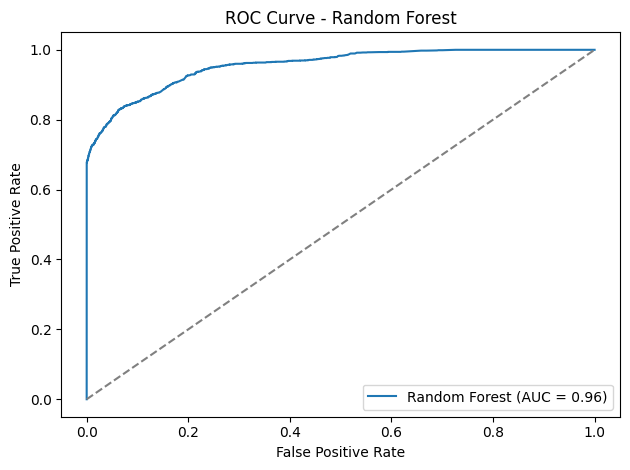

In [ ]:
#Biểu đồ ROC
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_rf:.2f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve_rf.png", dpi=300)
plt.show()

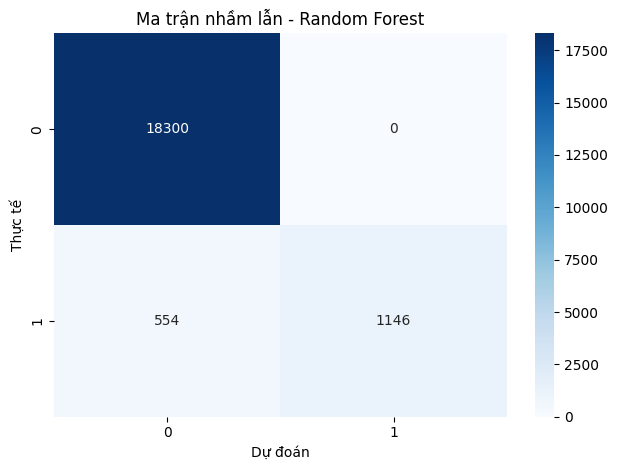

In [ ]:
#Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Ma trận nhầm lẫn - Random Forest")
plt.tight_layout()
plt.savefig("confusion_matrix_rf.png", dpi=300)
plt.show()
